# h2o's AutoML
Imputed unknown values and scaling carried out for some features.

## Imports

In [1]:
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import KFold
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score as acc
from scipy.stats import hmean 
from numpy import argmax
from sklearn.metrics import roc_auc_score as ras
import h2o
from sklearn.preprocessing import StandardScaler as ss

## Reading Data
#### ...and some simple analysis.

In [42]:
df_test=pd.read_csv('test.csv')
df_train=pd.read_csv('train.csv')

In [43]:
#checking for null values
df_train.isnull().values.any()

False

In [44]:
df_train.shape

(31649, 18)

In [45]:
df_test.shape

(13562, 17)

In [46]:
df_test.head()

,serial_number,age_in_years,job_description,marital_status,education_details,has_default,balance_in_account,housing_status,previous_loan,phone_type,date,month_of_year,call_duration,campaign_contacts,days_passed,previous_contact,poutcome_of_campaign
0,1,33,admin.,married,secondary,no,796,yes,no,telephone,6,apr,216,1,-1,0,unknown
1,2,40,management,married,secondary,no,754,no,yes,cellular,6,apr,635,1,-1,0,unknown
2,3,30,technician,single,secondary,no,10152,yes,no,cellular,6,apr,1108,2,270,1,failure
3,4,44,blue-collar,married,secondary,no,545,yes,no,cellular,6,apr,122,3,136,1,failure
4,5,35,technician,married,secondary,no,5553,yes,no,cellular,6,apr,371,3,136,7,failure


In [47]:
df_train.head()

,serial_number,age_in_years,job_description,marital_status,education_details,has_default,balance_in_account,housing_status,previous_loan,phone_type,date,month_of_year,call_duration,campaign_contacts,days_passed,previous_contact,poutcome_of_campaign,outcome
0,1,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,2,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,3,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,4,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,5,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


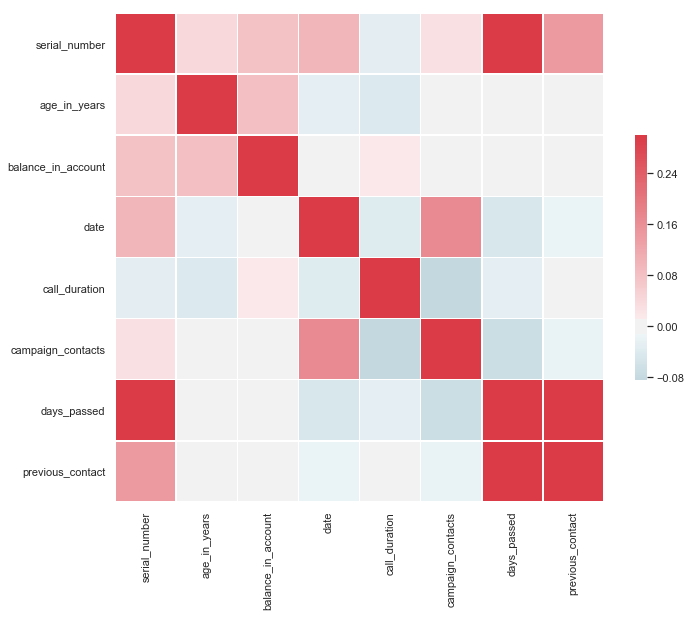

In [48]:
sns.set(style="white")
corr = df_train.corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

### Feature Preprocessing

**Imputing**

In [49]:
dataset_new=df_train
test_final=df_test
def impute_unknowns(df, column):
    col_values = df[column].values
    df[column] = np.where(col_values=='unknown', df_train[column].mode(), col_values)
    return df
dataset_new = impute_unknowns(df=dataset_new, column='job_description')
dataset_new = impute_unknowns(df=dataset_new, column='education_details')
test_final = impute_unknowns(df=df_test, column='job_description')
test_final = impute_unknowns(df=test_final, column='education_details')

**Scaling**

To scale: Age, Balance, Call Duration, days passed.

In [50]:
scaled_train = pd.DataFrame(dataset_new).copy()

col_names = ['age_in_years', 'balance_in_account', 'call_duration', 'days_passed']
features = scaled_train[col_names]
scaler = ss().fit(features.values)
features = scaler.transform(features.values)

scaled_train[col_names] = features
#strangely, age_in_years had a duplicate column at the end, so we drop it here
#scaled_train=scaled_train.drop(scaled_train.columns[18],axis=1)
scaled_train.head() 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,serial_number,age_in_years,job_description,marital_status,education_details,has_default,balance_in_account,housing_status,previous_loan,phone_type,date,month_of_year,call_duration,campaign_contacts,days_passed,previous_contact,poutcome_of_campaign,outcome
0,1,1.759644,management,married,tertiary,no,0.286923,yes,no,unknown,5,may,0.032751,1,-0.245808,0,unknown,no
1,2,0.300930,technician,single,secondary,no,-0.426992,yes,no,unknown,5,may,-0.386551,1,-0.245808,0,unknown,no
2,3,-0.845201,entrepreneur,married,secondary,no,-0.436110,yes,yes,unknown,5,may,-0.672439,1,-0.245808,0,unknown,no
3,4,0.613512,blue-collar,married,secondary,no,0.071803,yes,no,unknown,5,may,-0.611450,1,-0.245808,0,unknown,no
4,5,-0.845201,blue-collar,single,secondary,no,-0.436448,no,no,unknown,5,may,-0.207395,1,-0.245808,0,unknown,no


In [52]:
scaled_test = pd.DataFrame(test_final).copy()

col_names = ['age_in_years', 'balance_in_account', 'call_duration', 'days_passed']
features = scaled_test[col_names]
scaler = ss().fit(features.values)
features = scaler.transform(features.values)

scaled_test[col_names] = features

scaled_test.head() 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,serial_number,age_in_years,job_description,marital_status,education_details,has_default,balance_in_account,housing_status,previous_loan,phone_type,date,month_of_year,call_duration,campaign_contacts,days_passed,previous_contact,poutcome_of_campaign
0,1,-0.593734,admin.,married,secondary,no,-0.225389,yes,no,telephone,6,apr,-0.226544,1,-0.751832,0,unknown
1,2,-0.041526,management,married,secondary,no,-0.238410,no,yes,cellular,6,apr,1.480904,1,-0.751832,0,unknown
2,3,-0.830394,technician,single,secondary,no,2.675073,yes,no,cellular,6,apr,3.408405,2,1.104533,1,failure
3,4,0.274022,blue-collar,married,secondary,no,-0.303202,yes,no,cellular,6,apr,-0.609600,3,0.186625,1,failure
4,5,-0.435960,technician,married,secondary,no,1.249333,yes,no,cellular,6,apr,0.405089,3,0.186625,7,failure


In [1]:
def age_(data):
    
    data['Adult'] = 0
    data['Middle_Aged'] = 0
    data['old'] = 0    
    data.loc[(data['age_in_years'] <= 35) & (data['age_in_years'] >= 18),'Adult'] = 1
    data.loc[(data['age_in_years'] <= 60) & (data['age_in_years'] >= 36),'Middle_Aged'] = 1
    #data.loc[(data['age'] <= 60) & (data['age'] >= 46),'Elderly'] = 1
    data.loc[data['age_in_years'] >=61,'old'] = 1
    
    return data


def duration_(data):
    
    data['t_min'] = 0
    data['t_e_min'] = 0
    data['e_min']=0
    data.loc[data['call_duration'] <= 5,'t_min'] = 1
    data.loc[(data['call_duration'] > 5) & (data['call_duration'] <= 10),'t_e_min'] = 1
    data.loc[data['call_duration'] > 10,'e_min'] = 1
    
    return data

def pdays_(data):
    data['pdays_not_contacted'] = 0
    data['months_passed'] = 0
    data.loc[data['days_passed'] == -1 ,'pdays_not_contacted'] = 1
    data['months_passed'] = data['days_passed']/30
    data.loc[(data['months_passed'] >= 0) & (data['months_passed'] <=2) ,'months_passed'] = 1
    data.loc[(data['months_passed'] > 2) & (data['months_passed'] <=6),'months_passed'] = 2
    data.loc[data['months_passed'] > 6 ,'months_passed'] = 3
    
    return data


In [ ]:
dataset_1 = age_(dataset_new)
dataset_1 = duration_(dataset_new)
dataset_1 = pdays_(dataset_new)


test_1 = age_(test_final)
test_1 = duration_(test_final)
test_1 = pdays_(test_final)

dataset_1.info()

## Data separation

In [53]:
frame_sno = scaled_test['serial_number'] #serial numbers
frame_train_target = pd.DataFrame(scaled_train['outcome']) #Y of train
frame_train = scaled_train.drop(['outcome','serial_number'], axis = 1) #X array of train
frame_test = scaled_test.drop(['serial_number'], axis = 1) #testdata array
frame_test.shape

(13562, 16)

## Adopting Ninjarao's Encoding

### Target Variable

In [54]:
encoder= LabelEncoder()
dataset_encoded= encoder.fit_transform(frame_train_target['outcome'])
dataset_encoded
frame_train_target['outcome']=dataset_encoded


In [55]:
frame_train_target.drop_duplicates()

,outcome
0,0
83,1


### Binary features

In [56]:
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in frame_train:
    if frame_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(frame_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(frame_train[col])
            # Transform both training and testing data
            frame_train[col] = le.transform(frame_train[col])
            frame_test[col] = le.transform(frame_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)


3 columns were label encoded.


### One hot for other categoricals

In [57]:
frame_train = pd.get_dummies(frame_train)#One hot encoding(Prolly better ways of doing this)
frame_test = pd.get_dummies(frame_test)

train_labels = frame_train_target
# Align the training and testing data, keep only columns present in both dataframes
frame_train, frame_test = frame_train.align(frame_test, join = 'inner', axis = 1)

# Add the target back in
frame_train['outcome'] = train_labels

print('Training Features shape: ', frame_train.shape)
print('Testing Features shape: ', frame_test.shape)


Training Features shape:  (31649, 46)
Testing Features shape:  (13562, 45)


### Viewing

In [58]:
#frame_train

## Conversion into arrays 

In [59]:
sno = frame_sno.values 
#train_target = frame_train_target.values
#train = np.array(frame_train) 
#test = np.array(frame_test) 
#frame_train.shape

## AutoML
#### Initialization

In [60]:
h2o.init()
from h2o.automl import H2OAutoML

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,33 mins 00 secs
H2O cluster timezone:,Asia/Muscat
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.2
H2O cluster version age:,18 days
H2O cluster name:,H2O_from_python_Chinmayan_f4883o
H2O cluster total nodes:,1
H2O cluster free memory:,3.318 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


#### Preparing Data

In [61]:
hT = h2o.H2OFrame(frame_train)
x = hT.columns
y ='outcome'
x.remove(y)
hT['outcome'] = hT['outcome'].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%


### Letting AutoML do the work

In [62]:
aml = H2OAutoML(nfolds=10, max_runtime_secs = 60*3, stopping_metric='logloss', sort_metric='logloss', seed=79)
aml.train(x = x, y = y, training_frame=hT)

AutoML progress: |█████████████████████████████████████████████████████████████| 100%


In [63]:
aml.leaderboard

model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_2_AutoML_20181210_234817,0.955802,0.115047,0.159595,0.188181,0.0354121
GBM_3_AutoML_20181210_234817,0.955277,0.116107,0.171245,0.189131,0.0357705
GBM_1_AutoML_20181210_234817,0.954904,0.116357,0.161851,0.189023,0.0357296
GBM_4_AutoML_20181210_234817,0.953607,0.118998,0.187153,0.191499,0.0366717
StackedEnsemble_AllModels_AutoML_20181210_234817,0.952845,0.132231,0.161922,0.193758,0.0375424
StackedEnsemble_BestOfFamily_AutoML_20181210_234817,0.952205,0.13245,0.174897,0.19382,0.0375662
XRT_1_AutoML_20181210_234817,0.940391,0.136098,0.175584,0.191104,0.0365207
DRF_1_AutoML_20181210_234817,0.939215,0.138374,0.195945,0.191791,0.036784
GLM_grid_1_AutoML_20181210_234817_model_1,0.943858,0.13885,0.198874,0.198034,0.0392174


In [71]:
preds = aml.leader.predict(h2o.H2OFrame(frame_test))
preds = preds.as_data_frame()

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


## Preparing the submission

##### Rounding averaged values & decoding

In [72]:
outcomes=preds['predict']
outcomes.head()

0    0
1    1
2    0
3    0
4    0
Name: predict, dtype: int64

In [73]:

sub=pd.DataFrame({'outcome':outcomes})


In [74]:
sub[sub['outcome']==1.0]='yes'
sub[sub['outcome']==0.0]='no'
sub.drop_duplicates()

,outcome
0,no
1,yes


In [75]:
sub[sub['outcome']=='no'].shape[0]/sub.shape[0] #percentage of no

0.8687509216929656

In [76]:
sub['serial_number']=sno
sub=sub[['serial_number','outcome']]

In [77]:
sub.head()

,serial_number,outcome
0,1,no
1,2,yes
2,3,no
3,4,no
4,5,no


In [78]:
sub.to_csv("sub_automl_prep_scaled.csv", index=False)